# NNIA 18/19 Project 1:  PCA and & (Multiple) Linear Regression 

## Deadline: 07. December 2018, 23:59

**Important:** For all implementations in this project, make sure to use NumPy whenever possible. Most computations on vectors and matrices can be implemented very efficiently using the NumPy API. There is no need for looping over vectors etc. As a simple example, in order to compute the mean of a vector, just use `numpy.mean()`. If you are not familiar with NumPy please consult the NumPy tutorial that you find in the CMS under *Materials*. Further, in case of any doubts, the Forum is the best place to ask questions and discuss the project.  

In [0]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

---

## 1. Principal Component Analysis $~$ (15.0 points)

Features are our friends for prediction. For example, knowing the weight of a person is helpful for predicting his/her height. Knowing both the weight and age may improve the accuracy of our prediction. However, too many features could harm: each feature can be thought of as a dimension, $n$ features correspond to a $n$ dimensional space. In a high dimensional space ($n$ is very large), our data will distribute sparsely: if you draw unit grids in the space, the most of them will contain no data, which obstructs the learning process. This is called the *curse of dimensionality* (for more detail about the curse of dimensionality, see [here](http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)).


To overcome the curse of dimensionality, we simply reduce the dimensionality (i.e. reduce the number of features). We can either select a subset of all features, or we can apply PCA on our dataset. By specifying a $d$ ($d$<$n$), PCA will project our $n$ dimensional data onto a $d$ dimensional (affine) space. The assumption is that classification/regression should be easier in this $d$ dimensional space.

A tutorial of PCA can be found here: [PCA Tutorial](http://www.iro.umontreal.ca/~pift6080/H09/documents/papers/pca_tutorial.pdf) 

The goal of this exercise is to apply PCA on a small dataset: [The Digits Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits) 

#### 1.1. Data Normalization
Before applying PCA to our data, we first need to center the features by subtracting the mean of each feature. That is, given a design matrix $X \in \mathbb{R}^{n \times d}$ ($n$ samples, each with $d$ dimensional features), we apply the following formula:

\begin{equation*}
  \hat{x_{ij}} = x_{ij} - \mu(x_i) \textrm{ for } i = 1,\cdots, d, j = 1,\cdots,n
\end{equation*}

where $\mu(x_i)$ is the mean of the $i$-th column of $X$.

**Question 1:** Is this centering step important regarding the performance of the PCA? What might happen if we don't center our data? (1 point)

*Answer:*  

Mean centering is necessary for performing classical PCA to ensure that the first principal component describes the direction of maximum variance. If mean subtraction is not performed, the first principal component might instead correspond more or less to the mean of the data.

Argument:
Main procedure to perform PCA is :Data -> Cov matrix -> Eigendecomposition.
But, cov matrix of centered and non-centered data are same, which eventually leads to similar eigen decomposition. The reason for obtaining same covariance matrix is that cov matrix implicitly involves mean centering.

Note: Classical PCA is PCA in which eigendecomposition is done on matrix $X^TX/(n-1)$. In this case data matrix $X$ is not mean centered and hence it must be mean centered before performing the eigen decomposition. Also, if the data is mean centered then $X^TX/(n-1)$ will be cov matrix.

Reference: PCA Wikipedia


**Task 1:** Implement the following function which performs data normalization (i.e. normalize the columns of $X$) according to the description above. (1 point)

In [0]:
def data_normalization(data):
    # TODO: implement
    mean = np.mean(a=data, axis=0)  
    data_normalized = np.subtract(data, mean)
    return data_normalized

from sklearn.datasets import load_digits
digits = load_digits()
# temp = np.mean(a=digits.data, axis=0)
# print(digits.data.shape)
# print(temp)

# normalization check
d_n = data_normalization(digits.data)
a =  np.sum(d_n, axis=0)

#### 1.2  Apply PCA on Digits Dataset
In the following we will apply PCA on the digits dataset from sklearn. This dataset consists of 1797 images of size 8X8, each images contain a handwritten digit (0-9).
The digits look as follows:
![Image of digits](https://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png)

In [0]:
# import the digits dataset
from sklearn import datasets

In [0]:
# perform data normalization
data_matrix = datasets.load_digits().data
targets = datasets.load_digits().target
data_normalized = data_normalization(data_matrix)

Before applying PCA, let's take a look on a subset of original features and analyse whether they are discriminative for digits classification.

**Task 2:** Implement the following using matplotlib: (2 points)
1. Construct a 2D scatter plot. Plot the value of feature 0 (on $x$ axis) and feature 2 (on $y$ axis) for each data point, use different colors indicating different classes. 
2. Set corresponding labels: assign label "feature 0" for $x$ axis and "feature 2" for $y$ axis.
3. Set the title of the plot as "A subset of original features".
4. Show legends for each class.
5. After you have finished the first four steps and plotted the graph, you might observe that many data points overlap. This is because many data points have exactly the same value w.r.t. feature 0 and feature 2. In order to have a better visualization, please jitter the data points in your scatter plot, this step is called jittering. For more details about jittering, see [here](https://stats.stackexchange.com/questions/253009/why-jitter-continuous-value-in-a-scatterplot).



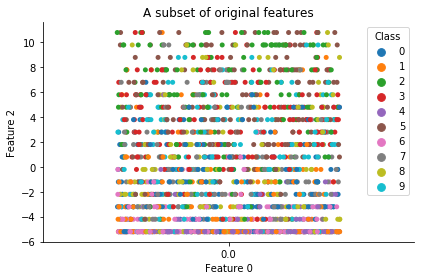

In [0]:
# TODO: Construct a 2D scatter plot
x = data_normalized[:,0] 
y = data_normalized[:,2]

digits_two_features = np.array([x,y]).T
y_response = targets
principalDf = pd.DataFrame(data = digits_two_features, columns = ['Feature 0', 'Feature 2'])
response = pd.DataFrame(y_response, columns=['Class'])
finalDf = pd.concat([principalDf, response], axis = 1)
sns.stripplot(x=x, y=y, hue=finalDf['Class'], data=response, jitter=0.3)
sns.despine()
plt.xlabel("Feature 0")
plt.ylabel("Feature 2")
plt.title('A subset of original features');
plt.tight_layout()

**Question 2:** What is the dimensionality of the new feature space? Is is easy to perform digit classification in this feature space? Justify your answer. (1 point)

*Answer:* 

The dimensionality of new feature space is 2. No, its not easy to perform digit classification. Because as depicted in the scatter plot above, the features are over-lapping(meaning different classes have same features) in 2d space, especially "Feature 0" is not all descriminative with having value as 0 for all classes. Even if the classifier is designed, it will not generalize becasue the features are not descriminant enouggh to identify different digits.



**Task 3:** Implement the function `PCA()` below. The input of this function is a normalized dataset and a parameter $d$, which specifies the output dimension (dimension of the projected space). The output should be a dataset/matrix of $\mathbb{R}^{n \times d}$. (Hint: `numpy.linalg.eig()` might be helpful here.) (4 points)

In [0]:
def PCA(data, d):
    """
    perform PCA on a dataset
    :param data: input dataset with shape (n,k).
    :param d: dimension of the output space.
    :return: a matrix of shape (n,d). where each row represents the (PCA) projection of each data point.
    """
    # TODO: implement
    # REMARK: note the eigenvalues/eigenvectors returned by np.linalg.eig() might not be ordered. 
    # You may want to order them first. 
    
    # covarinace of the normalized data
    cov_mat = np.cov(data.T)
    
    
#     print("cov_mat:\n", cov_mat.shape)
    # eigen decomposition of covariance matrix
    eig_values, eig_vectors = np.linalg.eig(cov_mat)
    
#     print("eig_values:\n", eig_values.shape)
#     print("eig_vectors:\n", eig_vectors.shape)
    
    eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))]
#     print("eig_pairs:\n", eig_pairs)
    
    
    # eigen vectors should be sorted
#     eig_pairs.sort()
#     eig_pairs.reverse()

    eig_vecs_sorted = []
    for i in eig_pairs:
        eig_vecs_sorted = np.append(eig_vecs_sorted, i[1], axis=0)
        
    eig_vectors_sorted = np.reshape(eig_vecs_sorted, (len(eig_pairs),len(eig_pairs))).T
#     print("eig_vectors_sorted:\n", eig_vectors_sorted)
    
    selected_eig_vectors = eig_vectors_sorted[:, 0:d]
#     print("selected_eig_vectors: \n", selected_eig_vectors)
    
    projected_data = np.dot(data, selected_eig_vectors)
    
    print("projected_data:\n", projected_data)
    
    return projected_data
    
    
    
    
# A = np.array([[1, 2], [3, 4], [5, 6]])
# A
# data = data_normalization(A)
# pca_data = PCA(data, 2)
# print("proj data:\n", pca_data)

**Task 4:** Apply `PCA()` on the normalized dataset using $d=2$, then construct a 2D scatter plot presenting the data points in the projected space. (2 points)

Requirements for the 2D scatter plot:
1. Plot the value of the first principle components (on $x$ axis) and the second principle components (on $y$ axis) of each data point, use different colors for each class. 
2. Set corresponding labels: assign label "first principle component" for $x$ axis and "second principle component" for $y$ axis.
3. Set the title of the plot as "2 component PCA".
4. Add legends for each class.


In [0]:
# TODO: perform PCA on mean centered dataset
projected_data = PCA(data_normalized, d=2)

projected_data:
 [[  1.25946645 -21.27488348]
 [ -7.9576113   20.76869896]
 [ -6.99192297   9.95598641]
 ...
 [-10.8012837    6.96025223]
 [  4.87210009 -12.42395362]
 [  0.34438963  -6.36554919]]


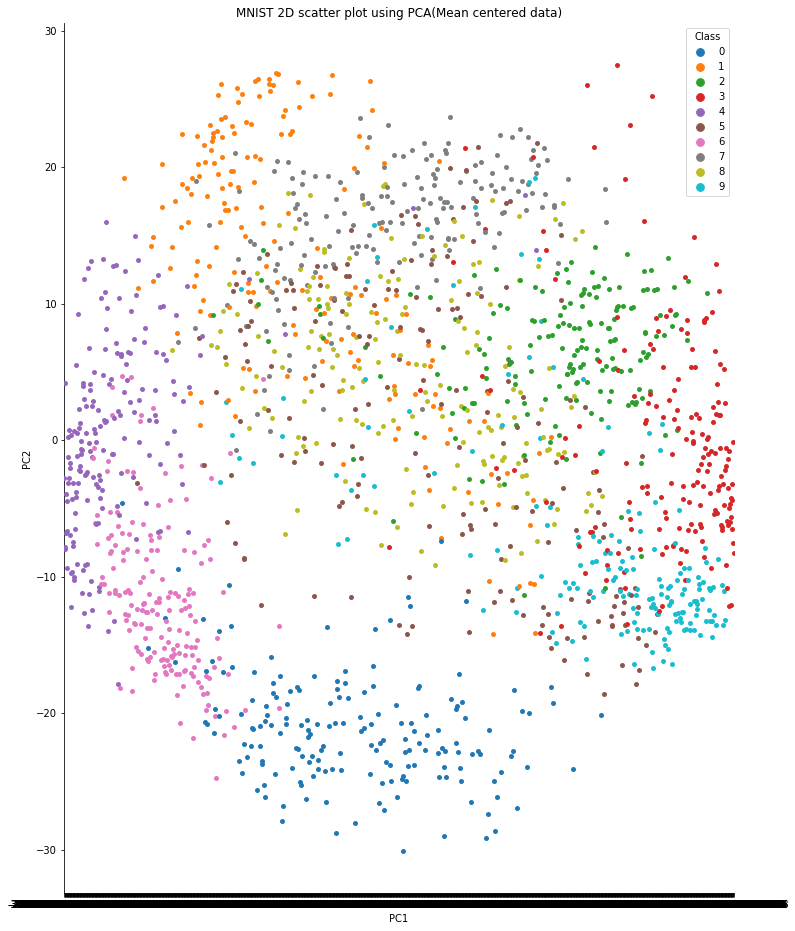

In [0]:
# TODO: Construct a 2D scatter plot
x = projected_data[:,0] 
y = projected_data[:,1]

digits_two_features = np.array([x,y]).T
y_response = targets
principalDf = pd.DataFrame(data = digits_two_features, columns = ['PC1', 'PC2'])
response = pd.DataFrame(y_response, columns=['Class'])
finalDf = pd.concat([principalDf, response], axis = 1)
fig = plt.figure(figsize=(12,16))
sns.stripplot(x=x, y=y, hue=finalDf['Class'], data=response)
sns.despine()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('MNIST 2D scatter plot using PCA(Mean centered data)');

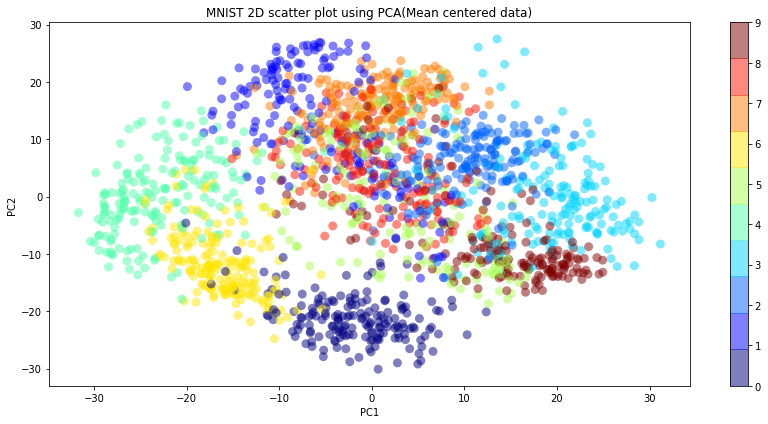

In [0]:
# TODO: Construct a 2D scatter plot
fig, plot = plt.subplots()
fig.set_size_inches(12, 6)
plt.prism()
plt.scatter(projected_data[:, 0], projected_data[:, 1], c=y_response, edgecolor='none', alpha=0.5,
           cmap=plt.get_cmap('jet', 10), s=80, label=labels)
plt.colorbar()
# plot.set_xticks(())
# plot.set_yticks(())
# plt.legend()
plt.title("MNIST 2D scatter plot using PCA(Mean centered data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

**Question 3:** Is it easier to perform classification on the transformed space? Justify your answer. (1 point)

*Answer:*

Compared to 2D feature space that was available(in Task2), this feature space is more descriminative(because they are obtained along two directions which represents the largest variance of the data) and hence it is relatively easier to classify some of the clases.
However, even in this feature space some of the data points(eg. classes 7 and 9 are highly overlapping) are still overapping, this indicates that classifcation is possible but in this transformed space is also not enough for very good classifier which classifies all the classes correctly.

**Question 4:** Now, modify the function  `data_normalization()` you implemented above: in additional to centering, divide each feature/column by its standard deviation. Then apply `PCA()` on this standardized data. Does the performance of PCA improve? Describe your findings (instead of modifying the original function you implemented above, please implement it again in the cell below). (2 points)

***Remark:*** One problem could occur when you divide the feature by its standard deviation: the standard deviation might be zero and division by zero is undefined. However, a standard deviation of zero can only be possible when all the values of a feature/column are the same (all equal to the mean). In this case, those features have no discriminative power so they can be removed from the analysis. Your implementation should be able to handle this case: all columns with zero standard deviation should be removed before standardize the data.

In [0]:
def data_normalization_modified(data):
    # TODO: implement
    
    # removing the features/columns with zero standard deviation
    col_std = np.std(a=data, axis=0)
#     print(col_std)
    zero_idx = np.where(col_std == 0)[0]
#     print(zero_idx)
    data_modified = np.delete(arr=data, obj=zero_idx, axis=1)
    std = np.std(a=data_modified, axis=0)
#     print(std)
    
    # standardizin the data
    mean = np.mean(a=data_modified, axis=0)  
#     print(mean)
    data_normalized = np.divide(np.subtract(data_modified, mean), std)
    
    return data_normalized

# from sklearn.datasets import load_digits
# digits = load_digits()
# # temp = np.mean(a=digits.data, axis=0)
# # print(digits.data.shape)
# # print(temp)

# # normalization check
# d_n = data_normalization_modified(digits.data)
# # a =  np.sum(d_n, axis=0)
# np.mean(d_n[:,0])

In [0]:
# perform data standardization
data_matrix = datasets.load_digits().data
targets = datasets.load_digits().target
data_normalized_std = data_normalization_modified(data_matrix)

# TODO: perform PCA on Standardized dataset
projected_data_std = PCA(data_normalized_std, d=2)

projected_data:
 [[ 1.91421366  0.95450157]
 [ 0.58898033 -0.9246358 ]
 [ 1.30203906  0.31718883]
 ...
 [ 1.02259599  0.14791087]
 [ 1.07605522  0.38090625]
 [-1.25770233  2.22759088]]


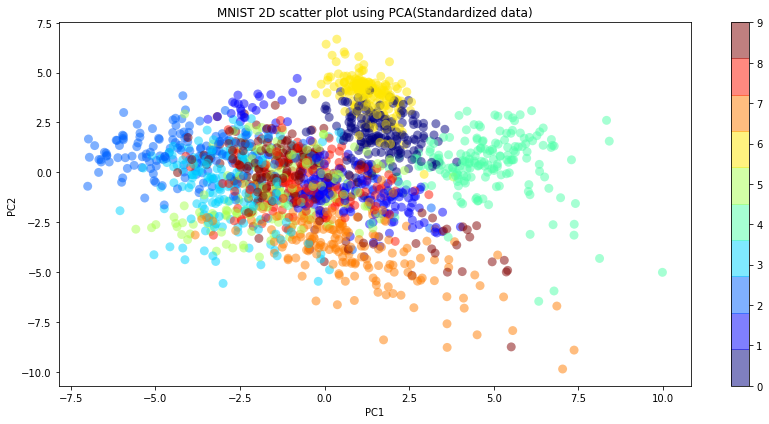

In [0]:
# TODO: Construct a 2D scatter plot based on PCs that is done using standardized data
fig, plot = plt.subplots()
fig.set_size_inches(12, 6)
plt.prism()
plt.scatter(projected_data_std[:, 0], projected_data_std[:, 1], c=y_response, edgecolor='none', alpha=0.5,
           cmap=plt.get_cmap('jet', 10), s=80, label=labels)
plt.colorbar()
# plot.set_xticks(())
# plot.set_yticks(())
# plt.legend()
plt.title("MNIST 2D scatter plot using PCA(Standardized data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

Question: Does the performance of PCA improve? 

*Answer:* 

From classification point of view PCA performance is not improve because more data points are overlapping compared to normalized PCA data points, which makes the classification difficult. Also, largest variance can be seen in one direction(diagonal), data distribution is considerable less in second dierction(just relative observation form figure, but not measured) 

One of the benefits of standardisation is to avoid numerical precision error when the order of magnitude of the variables are different. But in this case all the features are pixel values of image which are in the same order. Thus for this dataset standardizing may not be highly beneficial. But usage of standardization is dependent on the dataset.

Findings from plot:
Compared to scatter plot of mean centered PCA data, data points are overlapping more which shows that the standardization does not help much to build the classifier. In general when the variables have related physical meaning, it could be better to avoid standardisation, like in this case(all features are pixel values).


Finally, consider and the following (artificially generated) dataset:

array([[1.       , 0.0263109],
       [0.0263109, 1.       ]])

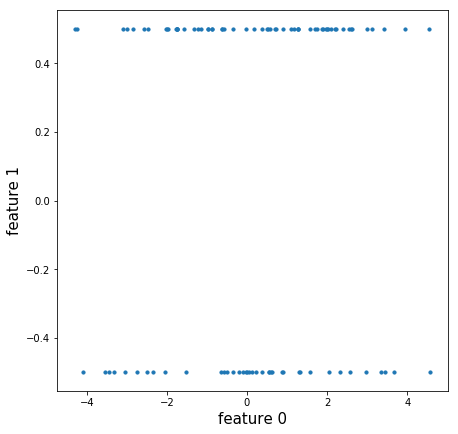

In [0]:
x = np.random.normal(loc=0.0, scale=2.0, size=100)
y = np.random.binomial(1, 0.5, size=100) - 0.5

fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('feature 0', fontsize = 15)
ax.set_ylabel('feature 1', fontsize = 15)
ax.scatter(x,y,s = 10);
np.corrcoef(x,y)

**Question 5:** Is PCA suitable for the above dataset? Justify your answer. (1 point)

*Answer:* 

For this dataset, applying PCA is possible, but in this case there are only two features and from dimensionality perspective PCA is not required because it is already in a low-dimension space. Besides, both x and y are highly uncorrelated(corr = 0.0263109) and there is no room to drop any of the feature thinking it as redundant feature by perfroming PCA. Thus PCA is not suitable for this dataset.

## Multiple Linear Regression (15.0 points)

In this exercise we will deal with *multiple linear regression*. Performing regression on one independent (or explanatory) variable and a scalar dependent variable is called **simple linear regression**.
But, when there are more than one explanatory variable (i.e. $x^{(1)}, x^{(2)}, ...,x^{(k)}$), and a single scalar dependent variable (*y*), then it's called **multiple linear regression**. (Please don't confuse this with *multivariate linear regression* where we predict more than one (correlated) dependent variable.)

Here, we will implement a **multiple linear regression** model in Python/NumPy using the *Gradient Descent* algorithm. Particularly, we will be using **stochastic gradient descent** (*SGD*) where one performs the update step using a small set of training samples of size *batch_size* which we will set to 64, i.e. we go through the training samples sampling 64 at a time and perform gradient descent. Such a procedure is sometimes called **mini-batch gradient descent** in the deep learning community.

Going through all the training samples *once* is called an **epoch**. Ideally, the algorithm has to go through multiple epochs over the training samples, each time shuffling it, until a convergence criterion has been satisfied.

Here, we will set a *tolerance value* for the difference in error (i.e. change in mean squared error (MSE) values between subsequent epochs) that we will accept. Once this difference falls below the *tolerance value*, we terminate our training phase and return the parameters. 

We repeat the above training procedure for all possible hyperparameter combinations in order to find the best parameters (i.e. weights) for our model. For this so called *hyperparameter tuning* we will be using the validation data. 

As a next step, we will combine training data and validation data and make it as our *new training data*. We keep the test data as it is. Using the hyperparameter combination (for the least MSE) that we found above, we train the model *again* with the *new training data* and obtain the parameter (*i.e. weight vector*) after convergence according to our *tolerance value*.

Phew! That will be our much desired *weight vector*. This is then used on the *test data*, which has not been seen by our algorithm so far, to make a prediction. The resulting MSE value will be the so-called [*generalization error*](https://en.wikipedia.org/wiki/Generalization_error). It is this *generalization error* that we want it to be as low as possible for *unseen data* (implies that we can achieve higher accuracy).

#### 2.1 Dataset
For our task, we will be using the *Wine Quality* dataset and predict the quality of white wine based on 11 features such as acidity, citric acid content, residual sugar etc. . You can take a glance of the data using functions like *data.head()*.

In [0]:
# get data
data_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
data = pd.read_csv(data_url, sep=';')

# inspect data
display(data.head())
print(data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


(4898, 12)


#### 2.2. Loss function
We will use a *regularized* form of the MSE loss function. In matrix form it can be written as follows:

\begin{equation*}
    J(\textbf{w}) = \frac{1}{2} \Vert{X\textbf{w}-\textbf{y}}\Vert^{2} + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}
\end{equation*}

It's important to note that, in the above equation, $X$, called **design matrix**, consists of data points in our dataset. Each row corresponds to a data point, each column correspondings to a feature. Therefore, the dimension of $X$ is *(number of data points, number of features)*. $X$ can be also thought as of the horizontal concatenation of shape *(batch_size, num_features)*. To make things easier, you can add the *bias* term as the first column of $X$. Take care to have the *weight* vector $\textbf{w}$ with matching dimensions. (Hint: see [Design_matrix#Multiple_regression](https://en.wikipedia.org/wiki/Design_matrix#Multiple_regression) for how $X$ with 2 features looks like for $1^{st}$ degree polynomial.)

**Task 5:** Derive the gradient (w.r.t $\textbf{w}$) for the regularized loss function given in 2.2. (1 point)

*Answer:*  
To derive the gradient, we need to differentiate it with respect to w and equate to zero, <br />
Before this, re-writing some terms <br />


\begin{equation*}
\Vert{X\textbf{w}-\textbf{y}}\Vert^{2}
= ({X\textbf{w}-\textbf{y}})^{T}*({X\textbf{w}-\textbf{y}})
\end{equation*}

$J(W)$ can be written in matrix form as:



\begin{eqnarray*}
&&J(\textbf{w}) = \frac{1}{2} \Vert{X\textbf{w}-\textbf{y}}\Vert^{2} + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}\\
\end{eqnarray*}
This can be written as:
\begin{eqnarray*}
&&J(\textbf{w}) = \frac{1}{2} (X\textbf{w}-\textbf{y})^T(X\textbf{w}-\textbf{y}) + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}\\
&& = \frac{1}{2} (W^TX^T - Y^T)(XW - Y) + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}\\
&& = \frac{1}{2} (W^TX^TXW + Y^TY - W^TX^TY - Y^TXW) + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}\\
&& = \frac{1}{2} (W^TX^TXW + Y^TY - (Y^TXW)^T - Y^TXW) + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}\\
\end{eqnarray*}
Now,  $Y^TXW$ is a 1X1 matrix so
$Y^TXW = (Y^TXW)^T$. Therefore, 
\begin{eqnarray*}
&& = \frac{1}{2} (W^TX^TXW + Y^TY - 2W^TX^TY) + \frac{\lambda}{2}\Vert{\textbf{w}}\Vert^{2}\\
&&\implies \frac{\delta J}{\delta w} = X^TXW - X^TY + 0 + \lambda W\\
&& = X^T(XW - Y) + \lambda W
\end{eqnarray*}

#### 2.3. Matrix format for higher order polynomial

Written in matrix form, a linear regression model for second order would look like: <br />
$$\hat{\textbf{y}} = X\textbf{w}_{1} + X^{2}\textbf{w}_{2} + \textbf{b}$$

where $X^{2}$ is the element-wise squaring of the original design matrix $X$, $\textbf{w}_1$ and $\textbf{w}_2$ are the *weight* vectors, and **b** is the *bias* vector.

**Task 6:** Please write down the matrix format for a $9^{th}$ order linear regression model. (0.5 point)

*Answer:* 

$$\hat{\textbf{y}} = X\textbf{w}_{1} + X^{2}\textbf{w}_{2} + X^{3}\textbf{w}_{3} +X^{4}\textbf{w}_{4} +X^{5}\textbf{w}_{5} +X^{6}\textbf{w}_{6} +X^{7}\textbf{w}_{7} +X^{8}\textbf{w}_{8} +X^{9}\textbf{w}_{9} +\textbf{b}$$

#### 2.4. Hyperparameters
Next, we will experiment with three hyperparameters:

i) regularization parameter $\lambda$ <br />
ii) learning rate $\epsilon$ <br />
iii) order of polynomial *p*

And do a grid search over the values that these hyperparameters can take in order to select the best combination (i.e. the one that achieves lowest test error). This approach is called **hyperparameter optimization or tuning**.

In [0]:
# Fix possible hyperparameters
polynomial_orders = [1, 5, 9]
learning_rates = [1e-5, 1e-8]
lambdas = [0.1, 0.8]

# Fix batch size
batch_size = 64

# Get data as NumPy array
data_values = data.values

#### 2.5. Normalization
First of all, inspect the data, and understand its structure and features. Ideally, before starting to train our learning algorithm, we would want the data to be normalized. Here, we normalize the data (i.e. normalize each column) using the formula:

\begin{equation*}
  norm\_x_i = \frac{x_i - min(x)}{max(x) - min(x)}
\end{equation*}
where $x_i$ is the $i^{th}$ sample in feature $x$. Note that this formula is different to the formula in the PCA part.

**Task 7:** Complete the following function which performs normalization (i.e. normalizes columns of $X$). (1 point)

In [0]:
# def data_normalization(data):
#     # TODO: implement
#     minimum = np.amin(data, axis=0, keepdims=True)
# #     print(minimum)
#     maximum = np.amax(data, axis=0, keepdims=True)
# #     print(maximum)
#     data_norm = np.subtract(data, minimum)/(maximum - minimum)
    
#     return data_norm


def data_normalization(data):
    # TODO: implement
    data_normalized = (data - data.min(axis = 0))/(data.max(axis = 0) - data.min(axis = 0))
    return data_normalized






# Perform data normalization
data_np = data_normalization(data_values);
# print first 5 rows
print(data_np)

[[0.30769231 0.18627451 0.21686747 ... 0.26744186 0.12903226 0.5       ]
 [0.24038462 0.21568627 0.20481928 ... 0.31395349 0.24193548 0.5       ]
 [0.41346154 0.19607843 0.24096386 ... 0.25581395 0.33870968 0.5       ]
 ...
 [0.25961538 0.15686275 0.11445783 ... 0.27906977 0.22580645 0.5       ]
 [0.16346154 0.20588235 0.18072289 ... 0.18604651 0.77419355 0.66666667]
 [0.21153846 0.12745098 0.22891566 ... 0.11627907 0.61290323 0.5       ]]


**Question 5:** How is the normalization here different from the standardization implemented in the PCA exercise (see Question 4 in the PCA part)? (1 point)

*Answer:* 


Normalization/standardization are designed to achieve a similar goal, which is to create features that have similar ranges to each other.

Normalization rescales the values into a range of [0, 1]. This is useful where all variables need to have the same positive scale. In this case, outlier will have larger influence.

Standardization removes the mean and scale the data with standard deviation such that varaibles will have unit variance and zero mean. In this case standardized data is not bounded unlike normalization. 

Please refer the corresponding functions for formulas.


In [0]:
# Split the data into training, validation, and test data
def split_data(data, n_train=3898, n_val=500, n_test=500):
    # (in-place) shuffling of data_npr along axis 0
    np.random.shuffle(data)

    n_val = n_train + n_val
    n_test = n_train + n_test
    
    X_train = data[0:n_train, 0:-1]
    Y_train = data[0:n_train, -1]
    
    X_val = data[n_train:n_val, 0:-1]
    Y_val = data[n_train:n_val, -1]
    
    X_test = data[n_test:, 0:-1]
    Y_test = data[n_test:, -1]
    
    return [(X_train, Y_train), (X_val, Y_val), (X_test, Y_test)]


# Shuffle only the training data along axis 0
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    perm = np.random.permutation(len(Y_train))
    Xtr_shuf = X_train[perm]
    Ytr_shuf = Y_train[perm]
    
    return Xtr_shuf, Ytr_shuf

#### 2.6. Implementation of required functions

**Task 8:** Complete the following function which computes the MSE value. You can ignore the regularization term and also the constants $\frac{1}{2}$. (0.5 point)

In [0]:
# # Compute Mean Squared Error 
# def compute_mse(prediction, ground_truth):
#     '''
#     :param prediction: a nx1 vector represents the prediciton of your model
#     :param ground_truth: a nx1 vector represents the ground_truth
#     :return: MSE loss
#     '''
#     # TODO: implement
# #     mse = (np.square(prediction - ground_truth)).mean(axis=0)
#     mse = ((prediction-ground_truth)**2).mean(axis=0)
    
#     return mse

def compute_mse(prediction, ground_truth):
    # TODO: implement
    mse = ((prediction-ground_truth)**2).mean(axis=0)
    #print(mse)
    return mse




**Task 9:** Implement a function which computes the prediction of your model. (0.5 point)

In [0]:
# def get_prediction(X, W):
#     '''
#     Given a design matrix X (could be a batch) and parameters W, calculate the prediction Y.
#     :param X: desgin matrix X of dimension nxd, where n is the number of data points (in the batch).
#     :param W: parameters
#     :return: the predictions
#     '''
#     # TODO: implement
# #     print("X:", X.shape)
# #     print("W:", W.shape)
#     pred = np.dot(X, W)
# #     print("pred:\n", pred[0:10])
    
#     return pred


def get_prediction(X, W):
    # TODO: implement
    Yhat = np.dot(X,W.T)
    return Yhat



**Task 10:** Implement a function which computes the gradient of your loss function. That is, implement the gradient computed in Task 5. (0.5 point)

In [0]:
# def compute_gradient(X, Y, Yhat, W, lambda_):
#     '''
#     :param X: designmatrix X
#     :param Y: ground truth labels correspoinding to X
#     :param Yhat: predicted labels
#     :param W: parameters
#     :param lambda_: coefficient for the regularizer
#     :return: gradient w.r.t W
#     '''
# #     print(X.shape, W.shape, Y.shape)
#     # TODO: implement
#     grad = np.dot(X.T,(np.dot(X,W))-Y) + lambda_*W
# #     grad = np.dot(X.T, (np.dot(X,W)) - Y) + lambda_ * W
# #     print("grad.shape", grad[:,0].shape)
# #     print("gradeint:",grad[:,0])
# #     print(grad.shape)
#     return grad


def compute_gradient(X, Y, Yhat, W, lambda_):
    # TODO: implement
    #print(X.shape, W.shape, Y.shape)
    gradient = np.dot(X.T,(np.dot(X,W))-Y) + lambda_*W #np.dot(np.dot((X,W.T - Y),X.t)) + lambda_*(W)
    return gradient



**Task 11:** Implement a function which performs a single update step of SGD. (0.5 point)

In [0]:
# # Hint: avoid in-place modification
# def sgd(gradient, lr, cur_W):
#     '''
#     :param gradient: gradient at cur_W
#     :param lr: learning rate
#     :param cur_W: current value of parameters
#     :return: apply gradient descent
#     '''
#     # TODO: implement
#     new_weights = cur_W - (lr * gradient)
    
#     return new_weights

def sgd(gradient, lr, cur_W):
    # TODO: implement
    new_W = cur_W - lr*gradient
    return new_W



**Task 12:** Complete the following function which reformats your data as a design matrix. (0.5 point)

In [0]:
# concatenate X acc. to order of polynomial; likewise do it for W
# where X is design matrix, W is the corresponding weight vector
# concatenate matrix X horizontally, concatenate W vertically. That is, after this transformation, X gets broader and W gets longer
# [1 X X^2 X^3], [1 W1 W2 W3].T.
# 
#####################
# def prepare_data_matrix(X, W, order):
#     # TODO: implement
#     '''
#     :param X: design matrix X
#     :param W: weight vector W
#     :param order: order of the polynomial
#     :return: extended X and W
#     '''
#     X_mat = np.ones(X.shape[0]).reshape(X.shape[0], 1)
#     W_mat = []
    
#     for poly in range(1, (order+1)):
#         X_mat = np.append(X_mat, np.power(X, poly), axis=1)    
#         W_mat = np.append(W_mat, np.power(W, poly))    
    
#     X, W = X_mat, np.append(1, W_mat).reshape(W_mat.shape[0]+1, 1)
# #     print(X.shape)
# #     print(W.shape)
    
#     return X, W
###############################
def prepare_data_matrix(X, W, order):
    # TODO: implement
    X_mat = np.concatenate((np.ones((X.shape[0],1)),X), axis = 1)
    W_vec = np.concatenate((np.ones((1,)).T,W.T), axis = 0)
    for i in range(2,order+1):
        X_mat = np.concatenate((X_mat, (X**i)), axis = 1)
        W_vec = np.concatenate((W_vec,W), axis = 0)
    return X_mat, W_vec.T


# X = np.ones((5,3))
# W = np.array([1,1,1])
# XX, WW = prepare_data_matrix(X, W, 2)
# XX.shape

#### 2.7. Training

**Task 13:** Complete the code in the following cell such that it performs **mini-batch gradient descent** on the training data for all possible hyperparameter combinations. (5 points)

Note: You can also define a function, named appropriately, which performs training. But, take care to do correct bookkeeping of hyperparameter combinations, weight vectors, and the MSE values.

In [0]:
# Get the data
splits = split_data(data_np)
X_train, Y_train, X_val, Y_val, X_test, Y_test = itertools.chain(*splits)

# Set tolerance value
tolerance = 1e-3
start = 1

# Initialize weight vector
W_init = np.random.randn(X_train.shape[1])

In [0]:
def train(X_train, W_init, polynomial_orders, learning_rates, lambdas):
    # Compute all hyperparameter combination
    comb_gen = itertools.product(*(polynomial_orders, learning_rates, lambdas))
    hparams_comb = list(comb_gen)
    
#     print("comb_gen", comb_gen, "\n")

#     print("hparams_comb", hparams_comb, "\n")

    # Cache weights for each hyperparam combination
    weights_hist = {hpm:0 for hpm in hparams_comb}
    mse_dict = {hpm:0 for hpm in hparams_comb}
    mse_hist = []
    
#     print("mse_hist", mse_hist)
#     print("mse_dict", mse_dict)
    
    
#     print("weights_hist", weights_hist, "\n")
#     print("mse_dict", mse_dict, "\n")

    # Find optimal hyperparameters
    for order in polynomial_orders:
        for lr in learning_rates:
            for lamb in lambdas:
                # Initialize 
                mse_hist.append(np.inf)
                mse_diff = np.inf 
#                 print("mse_hist",mse_hist)
                
                epochs = 1
                # TODO: Prepare data matrix
                data_mat, W_vec = prepare_data_matrix(X_train, W_init, order)
#                 print(X_train.shape)
#                 print("data_mat", "W_mat.shape", data_mat.shape, W_mat.shape)
    
                while True:
                    # TODO: shuffle the data
                    Xtr_shuf, Ytr_shuf = shuffle_train_data(data_mat, Y_train)
                    Y_hat = np.ones(Xtr_shuf.shape[0])
#                     print("Xtr_shuf.shape, Ytr_shuf.shape", Xtr_shuf.shape, Ytr_shuf.shape)
                    
                    iteration = 1
                    nsamples = Xtr_shuf.shape[0]
                    bs = 0
                    
                    # Perform a single epoch
                    while bs < nsamples:
                        Xtr = Xtr_shuf[bs: bs+batch_size]
                        Ytr = Ytr_shuf[bs: bs+batch_size]
                        
                        # TODO: do one step gradient descent
#                         print("Xtr.shape", Xtr.shape)
#                         print("W_mat.shape", W_mat.shape)
#                         print(Xtr.shape, Ytr.shape, W_mat.shape)
                        
                        grad = compute_gradient(Xtr, Ytr, Y_hat, W_vec, lamb)  
#                         print("grad:", grad)
                        W_vec = sgd(grad, lr, W_vec)
#                         print("new_weights:", new_weights)
        
                        bs += batch_size
                        iteration += 1

                    # TODO: do predcition on the entire (shuffled) dataset, compute mse and append it to the mse_hist
#                     print("new_weights.shape", new_weights.shape)
#                     print("Xtr_shuf.shape", Xtr_shuf.shape)
                    Y_hat = get_prediction(Xtr_shuf, W_vec)
#                     print("Y_hat", Y_hat.shape, "Ytr_Shuf", Ytr_shuf.shape)
                    mse = compute_mse(Y_hat, Ytr_shuf)
#                     print("mse", mse)
                    
    
                    mse_prev = mse_hist[-1]
                    mse_hist.append(mse)                
#                     print("MSE after epoch {} is {}".format(epochs, round(mse, 5)))
                    
                    #TODO: Stopping criterion: check whether diff-in-mse < tolerance
                    mse_diff = mse_prev - mse
#                     print("mse", "mse_prev", "mse_diff", mse, mse_prev, mse_diff)
                    
                    if mse_diff < tolerance:
                        #cache weight vector
                        weights_hist[(order, lr, lamb)] = W_vec
                        mse_dict[(order, lr, lamb)] = mse_hist[-1]
                        print("order: {} , learning rate: {} , regularizer: {} ".format(order, lr, lamb))
                        print("Convergence after epoch {} with MSE {}".format(epochs, round(mse_hist[-1], 5)), "\n")
                        break
                    epochs += 1
    
    return weights_hist, mse_hist






# Get the data
# print(data_np)

# # print(stop)
# splits = split_data(data_np)

# X_train, Y_train, X_val, Y_val, X_test, Y_test = itertools.chain(*splits)

# # print(X_train.shape, Y_train.shape, X_val.shape, X_test.shape, X_test.shape, Y_test.shape)
# # Set tolerance value
# tolerance = 1e-3
# start = 1

# # Initialize weight vector
# W_init = np.random.randn(X_train.shape[1])

# training 
# weights_hist, mse_hist = train(X_train, W_init, polynomial_orders, learning_rates, lambdas);

In [0]:
weights_hist, mse_hist = train(X_train, W_init, polynomial_orders, learning_rates, lambdas);

order: 1 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 31 with MSE 0.05436 

order: 1 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 31 with MSE 0.05269 

order: 1 , learning rate: 1e-08 , regularizer: 0.1 
Convergence after epoch 2 with MSE 0.47657 

order: 1 , learning rate: 1e-08 , regularizer: 0.8 
Convergence after epoch 2 with MSE 0.47657 

order: 5 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 202 with MSE 0.17832 

order: 5 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 197 with MSE 0.15535 

order: 5 , learning rate: 1e-08 , regularizer: 0.1 
Convergence after epoch 2 with MSE 1.70651 

order: 5 , learning rate: 1e-08 , regularizer: 0.8 
Convergence after epoch 2 with MSE 1.7065 

order: 9 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 265 with MSE 0.20235 

order: 9 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 256 with MSE 0.17105 

order: 9 , learning r

**Task 14:** Complete the following function which selects the best hyperparameter combination given a list of weights (i.e. the one that gives lowest MSE on **validation data**). (1 point)

In [0]:
# Select hparams of minimum MSE on Validation data
def select_best_hparams(X_val, W, Y_val):
    # TODO: Implement    
    hpm_best = ()
    mse_best = np.inf
    mse_best = np.zeros((1,1))
    # mse_best[0] = 100
    para_list = []
    for param_set in weights_hist:    
        order = (int)(param_set[0])
        lr = param_set[1]
        lamb = param_set[2]
        para_list.append(param_set)
        w_shape = X_val.shape[1]
        X_mat, W_mat = prepare_data_matrix(X_val, np.random.randn(w_shape), order)  
        weights = weights_hist[param_set]
        Y_hat = get_prediction(X_mat, weights)
        mse = compute_mse(Y_hat, Y_val)        
        mse_best = np.concatenate((mse_best, np.reshape(mse,(1,1))), axis = 0)
    
    
    mse_list = mse_best[1:len(mse_best)]
    print(mse_list, para_list)
    min_index = np.argmin(mse_list)
    #print(min_index)
    hpm_best, mse_best = para_list[min_index], mse_list[min_index]
    return hpm_best, mse_best


# best_hpm_combination, best_mse = select_best_hparams(X_val, weights_hist, Y_val)
# print("Best hyperparameters: ",best_hpm_combination)
# print("Best MSE: ", best_mse)

In [0]:
# TODO: Train the model with all possible hyperparameter combinations
# Get the data
splits = split_data(data_np)
X_train, Y_train, X_val, Y_val, X_test, Y_test = itertools.chain(*splits)

# Set tolerance value
tolerance = 1e-3
start = 1

# Initialize weight vector
W_init = np.random.randn(X_train.shape[1])

weights_hist, mse_hist = train(X_train, W_init, polynomial_orders, learning_rates, lambdas);

# TODO: Find best hyperparameter combination
best_hpm_combination, best_mse = select_best_hparams(X_val, weights_hist, Y_val)

print('Best hyperamarameters (on validation data): ', best_hpm_combination)
print('Corresponding MSE (on validation data): ', best_mse)

order: 1 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 31 with MSE 0.14772 

order: 1 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 31 with MSE 0.14404 

order: 1 , learning rate: 1e-08 , regularizer: 0.1 
Convergence after epoch 2 with MSE 0.45478 

order: 1 , learning rate: 1e-08 , regularizer: 0.8 
Convergence after epoch 2 with MSE 0.45478 

order: 5 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 265 with MSE 0.35531 

order: 5 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 272 with MSE 0.27791 

order: 5 , learning rate: 1e-08 , regularizer: 0.1 
Convergence after epoch 2 with MSE 1.34986 

order: 5 , learning rate: 1e-08 , regularizer: 0.8 
Convergence after epoch 2 with MSE 1.34986 

order: 9 , learning rate: 1e-05 , regularizer: 0.1 
Convergence after epoch 349 with MSE 0.45229 

order: 9 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 355 with MSE 0.33136 

order: 9 , learning 

#### 2.8. Re-Training on Train + Validation data
**Task 15:** Complete the following function which does re-training on the combined training and validation data. (1 point)

In [0]:
# Re-run the training on X_train + X_val combined

# TODO: implement
print(X_train.shape, X_val.shape)
X_train_comb = np.concatenate((X_train, X_val), axis = 0)
Y_train_comb = np.concatenate((Y_train, Y_val), axis = 0)

# print(X_train_comb.shape, Y_train_comb.shape)

# Initialize weight vector
W_comb_init = np.random.randn(X_train_comb.shape[1])

# Use already found best hparam comb
best_order, best_lr, best_lamb = best_hpm_combination

# Get data
X_mat, W_vec = prepare_data_matrix(X_train_comb, W_comb_init, best_order)

# Run training
# TODO: implement
# using the best hyperparameter set to tune the final model
polynomial_orders = [best_hpm_combination[0]]
learning_rates = [best_hpm_combination[1]]
lambdas = [best_hpm_combination[2]]
final_weights, mse_cache = train(X_mat, W_vec, polynomial_orders, learning_rates, lambdas)

(3898, 11) (500, 11)
order: 1 , learning rate: 1e-05 , regularizer: 0.8 
Convergence after epoch 32 with MSE 0.05463 



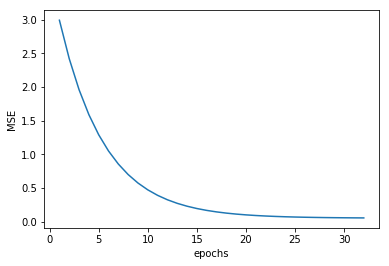

In [0]:
# Let's plot the convergence of MSE values on the train+validation dataset using matplotlib, i.e. #epochs on X-axis and MSE values on Y-axis
fig, axes = plt.subplots()
axes.plot(mse_cache)
axes.set_yscale('linear')
axes.set_xlabel("epochs")
axes.set_ylabel("MSE");

#### 2.9. Evaluation on Test set
**Task 16:** Evaluate your model on test data. (1 point)

In [0]:
# test your model on X_test with the weight vector that you found above
# this will be the generalization error of our model.

# TODO: implement
for para_set in final_weights:
    set = para_set
    
order = set[0]    
# print(final_weights[set].shape)
W_vec_final = final_weights[set][1:len(final_weights[set])]
X_mat_test, _ = prepare_data_matrix(X_test, np.random.rand(X_test.shape[1]), order)
Y_test_pred = get_prediction(X_mat_test, W_vec_final)
mse_test = compute_mse(Y_test_pred, Y_test)

print("MSE achieved on X_test is : {}".format(round(mse_test, 6)))

MSE achieved on X_test is : 0.127304


#### 2.10. Results
**Task 17:** Report the MSE value on the test data. (0.5 point)

*Answer:* 


    MSE achieved on X_test is : 0.127304

**Question 6:**  Which hyperparameter combination turned out to be the best? In your understanding, why do you think such a combination turned out to be the best for this task? (0.5 point)

*Answer:* 

    Best hyperamarameters (on validation data):  (1, 1e-05, 0.8)




---